In [17]:
!nvidia-smi

Wed May  3 15:07:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   47C    P8    20W / 170W |  11345MiB / 12045MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [9]:
!python -c "import tensorflow as tf;print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

2023-05-04 05:21:39.956898: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-04 05:21:41.132728: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-04 05:21:41.159185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 05:21:41.159796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 335.32GiB/s
2023-05-04 05:21:41.159883: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-04 05:21:41.162073: I tensorflow/stream_executor/

In [10]:
#and clone the TensorFlow Model Garden repository
!git clone https://github.com/tensorflow/models.git xxx



Cloning into 'xxx'...
remote: Enumerating objects: 85374, done.
remote: Counting objects: 100% (1002/1002), done.
remote: Compressing objects: 100% (463/463), done.
remote: Total 85374 (delta 608), reused 907 (delta 534), pack-reused 84372
Receiving objects: 100% (85374/85374), 598.54 MiB | 15.91 MiB/s, done.
Resolving deltas: 100% (61097/61097), done.


In [11]:
#using a older version of repo (21 Sept 2020)
%cd xxx
!git checkout -f e04dafd04d69053d3733bb91d47d0d95bc2c8199

/home/ubuntu/ai/xxx
Note: switching to 'e04dafd04d69053d3733bb91d47d0d95bc2c8199'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at e04dafd04 Add copybara presumbit metadata, and move files to root dir.


In [35]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
print(tf.__version__)


2.5.0


In [5]:
%cd /home/ubuntu/ai/data/

/home/ubuntu/ai/data


In [6]:
#creating two dir for training and testing
!mkdir test_labels train_labels

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 274/1370 labels (20% of the labels) to the testing dir: `test_labels`
!ls annotations/* | sort -R | head -274 | xargs -I{} mv {} test_labels/


# Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
!ls annotations/* | xargs -I{} mv {} train_labels/

sort: write failed: 'standard output': Broken pipe
sort: write error


In [7]:
#adjusted from: https://github.com/datitran/raccoon_dataset
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,   
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')   

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.
Successfully created label_map.pbtxt 


In [8]:
#Usage:  
#!python generate_tfrecord.py output.csv output_pb.txt /path/to/images output.tfrecords

#For train.record
!python generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

#For test.record
!python generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record


2023-05-01 01:19:30.550682: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
groups: 100%|███████████████████████████████| 684/684 [00:00<00:00, 1211.10it/s]
Successfully created the TFRecords: /home/ubuntu/ai/data/train.record
2023-05-01 01:19:32.912713: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
groups: 100%|███████████████████████████████| 274/274 [00:00<00:00, 1169.47it/s]
Successfully created the TFRecords: /home/ubuntu/ai/data/test.record


In [16]:
#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
#!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

%cd /home/ubuntu/ai/data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xzvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz


/home/ubuntu/ai/data
--2023-05-01 01:35:44--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.199.16, 2404:6800:4001:803::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.199.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  38.0MB/s    in 5.9s    

2023-05-01 01:35:50 (39.5 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/

In [15]:
!ls

anchor_generators
box_coders
builders
colab_tutorials
configs
CONTRIBUTING.md
core
data
data_decoders
dataset_tools
dockerfiles
eval_util.py
eval_util_test.py
exporter_lib_tf2_test.py
exporter_lib_v2.py
exporter_main_v2.py
exporter.py
exporter_tf1_test.py
export_inference_graph.py
export_tflite_ssd_graph_lib.py
export_tflite_ssd_graph_lib_tf1_test.py
export_tflite_ssd_graph.py
g3doc
inference
__init__.py
inputs.py
inputs_test.py
legacy
matchers
meta_architectures
metrics
model_hparams.py
model_lib.py
model_lib_tf1_test.py
model_lib_tf2_test.py
model_lib_v2.py
model_main.py
model_main_tf2.py
models
model_tpu_main.py
packages
predictors
protos
README.md
samples
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
test_data
test_images
tpu_exporters
utils


In [10]:
#copy the edited config file from the configs/tf2 directory to the data/ folder in your drive

!cp /home/ubuntu/ai/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /home/ubuntu/ai/data

In [36]:
%load_ext tensorboard
%tensorboard --logdir '/home/ubuntu/ai/data/training'

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-05-02 06:44:36.334240: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [37]:
%cd /home/ubuntu/ai/models/research
!protoc object_detection/protos/*.proto --python_out=.

/home/ubuntu/ai/models/research


In [38]:
%cd /home/ubuntu/ai/models/research/object_detection

/home/ubuntu/ai/models/research/object_detection


In [14]:
# Run the command below from the content/models/research/object_detection directory
"""
PIPELINE_CONFIG_PATH=path/to/pipeline.config
MODEL_DIR=path to training checkpoints directory
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

python model_main_tf2.py -- \
  --model_dir=$MODEL_DIR --num_train_steps=$NUM_TRAIN_STEPS \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --alsologtostderr
"""

!python model_main_tf2.py --pipeline_config_path=/home/ubuntu/ai/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/home/ubuntu/ai/data/training --alsologtostderr

2023-05-01 03:31:01.328387: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-01 03:31:02.710095: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-01 03:31:03.462635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 03:31:03.463163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 335.32GiB/s
2023-05-01 03:31:03.463219: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-01 03:31:03.464942: I tensorflow/stream_executor/

In [16]:
!mkdir /home/ubuntu/ai/data/inference_graph

mkdir: cannot create directory ‘/home/ubuntu/ai/data/inference_graph’: File exists


In [18]:
##Export inference graph
!python exporter_main_v2.py --trained_checkpoint_dir=/home/ubuntu/ai/data/training --pipeline_config_path=/home/ubuntu/ai/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --output_directory /home/ubuntu/ai/data/inference_graph

2023-05-01 07:53:05.288096: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-01 07:53:06.704285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-01 07:53:07.422824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 07:53:07.423357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 335.32GiB/s
2023-05-01 07:53:07.423444: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-01 07:53:07.425214: I tensorflow/stream_executor/

In [19]:
# Different font-type for labels text.(This step is optional)
!wget https://freefontsdownload.net/download/160187/arial.zip
!unzip arial.zip -d .

%cd utils/
!sed -i "s/font = ImageFont.truetype('arial.ttf', 24)/font = ImageFont.truetype('arial.ttf', 50)/" visualization_utils.py
%cd ..

--2023-05-01 07:54:30--  https://freefontsdownload.net/download/160187/arial.zip
Resolving freefontsdownload.net (freefontsdownload.net)... 172.67.180.27, 104.21.75.182, 2606:4700:3037::ac43:b41b, ...
Connecting to freefontsdownload.net (freefontsdownload.net)|172.67.180.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172821 (169K) [application/force-download]
Saving to: ‘arial.zip’

arial.zip           100%[===================>] 168.77K   236KB/s    in 0.7s    

2023-05-01 07:54:32 (236 KB/s) - ‘arial.zip’ saved [172821/172821]

Archive:  arial.zip
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@#################################@
@#        Downloaded from        #@
@#                               #@
@#   www.FreeFontsDownload.net   #@
@#                               #@
@# ---------- More site -------- #@
@#      https://funnytv.net      #@
@#                               #@
@#                               #@
@#################################@
@@@@@@@@@@@@@@@@@@@

In [1]:
!pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)


In [35]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
import cv2
warnings.filterwarnings('ignore')
from PIL import Image
#from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import time


In [43]:

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/home/ubuntu/ai/data/inference_graph/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/home/ubuntu/ai/data/label_map.pbtxt",use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

image_path = "/home/ubuntu/ai/data/test_images/img_4.jpg"
#print('Running inference for {}... '.format(image_path), end='')

image_np = load_image_into_numpy_array(image_path)
#image_np = cv2.imread(image_path)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)



Loading model...Done!


In [44]:
# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))

detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}

detections['num_detections'] = num_detections

boxes = detections['detection_boxes']

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)


array([[[ 67,  78,  62],
        [ 67,  78,  64],
        [ 56,  66,  55],
        ...,
        [ 25,  27,  26],
        [ 35,  37,  34],
        [ 47,  49,  46]],

       [[ 61,  72,  56],
        [ 72,  83,  67],
        [ 87,  97,  86],
        ...,
        [ 27,  29,  28],
        [ 37,  39,  36],
        [ 48,  50,  47]],

       [[ 64,  75,  58],
        [ 82,  93,  77],
        [140, 151, 135],
        ...,
        [ 28,  30,  29],
        [ 38,  40,  37],
        [ 48,  50,  47]],

       ...,

       [[140, 156, 169],
        [139, 155, 168],
        [139, 155, 168],
        ...,
        [ 48,  49,  54],
        [ 48,  49,  54],
        [ 48,  49,  54]],

       [[139, 156, 166],
        [139, 156, 166],
        [139, 155, 168],
        ...,
        [ 48,  49,  54],
        [ 48,  49,  54],
        [ 48,  49,  54]],

       [[139, 156, 166],
        [139, 156, 166],
        [139, 155, 168],
        ...,
        [ 48,  49,  54],
        [ 48,  49,  54],
        [ 48,  49,  54]]

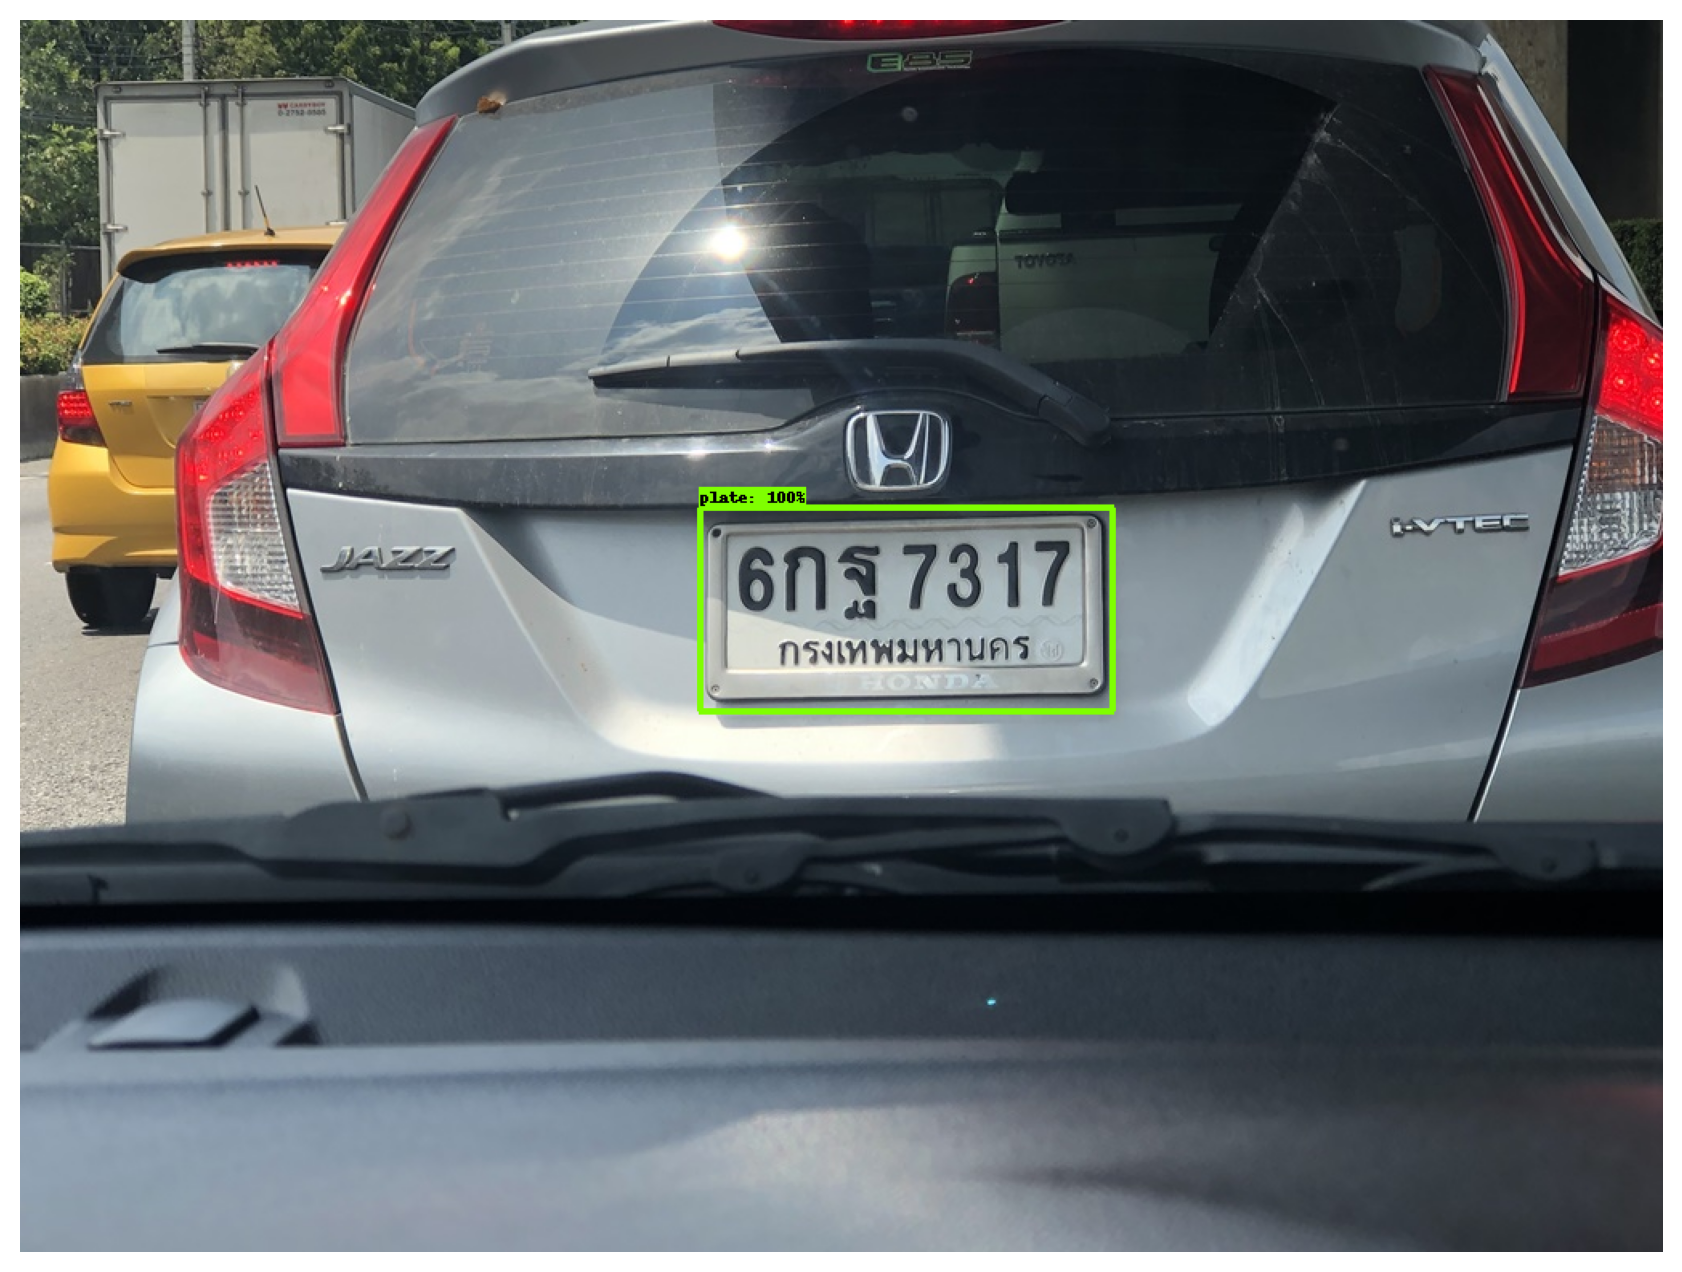

In [45]:
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()

In [46]:
image_height = image_np.shape[0]
image_width = image_np.shape[1]

print('Image Height       : ',image_height)
print('Image Width        : ',image_width)

Image Height       :  768
Image Width        :  1024


In [47]:
output = []
threshold = 0.95
j=1
for index, score in enumerate(detections['detection_scores']):
    if score < threshold:
        continue
    label = category_index[detections['detection_classes'][index]]['name']
    ymin, xmin, ymax, xmax = detections['detection_boxes'][index]
    output.append((label, j , int(ymin * image_height),  int(ymax * image_height) , int(xmin * image_width) , int(xmax * image_width)))
    j=j+1

In [48]:
output

[('plate', 1, 304, 430, 423, 681)]

In [49]:
curr_time = round(time.time()*1000)
print("Milliseconds since epoch:",curr_time)

for rows in output:
    print(rows[0]) # name
    print(rows[1]) # id
    I = rows[1]
    print(rows[2]) # ymin = X
    X = rows[2]
    print(rows[3]) # ymax = Y
    Y = rows[3]
    print(rows[4]) # xmin = W
    W = rows[4]
    print(rows[5]) # xmax = H
    H = rows[5]
    print()
    
    cropped_image = image_np_with_detections[X:Y, W:H]
    cv2.imwrite("/home/ubuntu/ai/data/output/cropped_image_1_{}_{}.jpg".format(int(I),curr_time), cropped_image)


Milliseconds since epoch: 1683202315438
plate
1
304
430
423
681



In [50]:
!ls /home/ubuntu/ai/data/output

Cropped_Image_1_1_1683202261553.jpg  Cropped_Image_1_2_1683202261553.jpg
Cropped_Image_1_1_1683202315438.jpg


In [53]:
!pip install numba 

In [54]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [55]:
!nvidia-smi

Thu May  4 05:14:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   51C    P8    20W / 170W |      2MiB / 12045MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------